# Can CNN classify sports? <hr/>
Nowadays, I have learnt golf every day, and suddenly I came up with an idea while playing golf. Can CNN classify sports?

First, I needed sports data, and I chose sports golf, baseball, soccer, and basketball.

I got datas from Google by using this method 'https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/'

There is a sample of data per sports.

### basketball
![basketball](./baketball_sample.PNG)

### baseball
![basetball](./baseball_sample.PNG)

### soccer
![soccer](./soccer_sample.PNG)

### golf
![golf](./golf_sample.PNG)

Pretty messy.. but this is somewhat organized. i removed a lot unrecognizable photos include this one

### bad one
<img src="./bad_sample.jpg" width="400">

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random
import datetime
print(os.listdir())

['.ipynb_checkpoints', 'bad_sample.jpg', 'baketball_sample.PNG', 'baseball_sample.PNG', 'golf_sample.PNG', 'main.ipynb', 'soccer_sample.PNG', 'test', 'train']


In [2]:
TRAINING_DIR = './train'
TEST_DIR = './test'

## Import datas

Imported images to 100 x 100 size and made a list of correct answers

Data map :

soccer : 0

baseball : 1

basketball : 2

golf : 3

In [3]:
def get_data(name):
    x = []
    y = []
    
    for file in os.listdir(name+'/'):
        if file.startswith('soccer'):
            value = 0
        elif file.startswith('baseball'):
            value = 1
        elif file.startswith('baketball'):
            value = 2
        else:
            value = 3
            
        img = cv2.imread(name+'/'+'/'+file)
        
        if img is not None:
            img = cv2.resize(img,(100, 100))
            img = np.array(img)
            x.append(img)
            y.append(value)
    return np.array(x), np.array(y)

In [4]:
trainx, trainy = get_data(TRAINING_DIR)

In [5]:
testx, testy = get_data(TEST_DIR)

In [6]:
trainx.shape, testx.shape

((5443, 100, 100, 3), (1469, 100, 100, 3))

## Built Batch Generator

In [7]:
class BatchGenerator():
    where = 0
    
    def __init__(self, x, y, batch_size, one_hot = False, nb_classes = 0):
        self.nb_classes = nb_classes
        self.one_hot = one_hot
        self.x_ = x
        self.y_ = y
        self.batch_size = batch_size
        
        self.total_batch = int(len(x) / batch_size)
        self.x = self.x_[:batch_size,]
        self.y = self.y_[:batch_size,]
        self.where = batch_size
        
        if self.one_hot :
            self.set_one_hot()

    def next_batch(self):
        if self.where + self.batch_size > len(self.x_) :
            self.where = len(self.x_) - self.where
            
        self.x = self.x_[self.where:self.where+self.batch_size,]
        self.y = self.y_[self.where:self.where+self.batch_size,]
        self.where += self.batch_size
        
        if self.one_hot:
            self.set_one_hot()
        
    def set_one_hot(self):
        self.y = np.int32(self.y)
        one_hot = np.array(self.y).reshape(-1)
        self.y = np.eye(self.nb_classes)[one_hot]

## Modeling

I was using only simple CNN with Batch Nomalization

If you want to know about Batch Nomalization check it out 'https://github.com/che9992/Batch_Normalization'

In [8]:
def conv2d(inp, size, kernel_size, stride, scope):
    with tf.variable_scope(scope):
        return tf.contrib.layers.conv2d(inp, size, kernel_size=kernel_size, stride=stride, activation_fn=None,
                                        padding='SAME', reuse=tf.AUTO_REUSE, scope = scope)
    
def relu(inp, phase, scope):
    with tf.variable_scope(scope):
        bn = tf.contrib.layers.batch_norm(inp, center = True, scale = True, is_training= phase, scope='bn', reuse=tf.AUTO_REUSE)
        return tf.nn.relu(bn, name = 'relu')
    
def max_pooling(inp, kernel_size, strides, name):
    return tf.nn.max_pool(inp, ksize=kernel_size, strides=strides, padding='SAME', name=name)

def fully_connected(inp, size, scope):
    return tf.contrib.layers.fully_connected(inp, size, activation_fn=None, scope=scope, reuse=tf.AUTO_REUSE)

### Convolutions

I made eight convolutions with relu and max pooling for CNN 

In [9]:
tf.reset_default_graph() 
nb_classes = 4
phase_ = tf.placeholder(dtype=tf.bool, name = 'phase')
X = tf.placeholder(shape=[None, 100, 100, 3], dtype=tf.float32, name='X')
Y = tf.placeholder(shape=[None, nb_classes], dtype=tf.float32, name='Y')

def model(X):
    conv_1 = conv2d(X, 32, [1,1], [1,1], 'conv_1')
    relu_1 = relu(conv_1, phase_, 'relu_1')
    max_1 = max_pooling(relu_1, [1,2,2,1], [1,1,1,1], 'max_1')
    
    conv_2 = conv2d(max_1, 128, [1,1], [1,1], 'conv_2')
    relu_2 = relu(conv_2, phase_, 'relu_2')
    max_2 = max_pooling(relu_2, [1,2,2,1], [1,1,1,1],'max_2')
    
    conv_3 = conv2d(max_2, 256, [1,1], [1,1], 'conv_3')
    relu_3 = relu(conv_3, phase_, 'relu_3')
    max_3 = max_pooling(relu_3, [1,2,2,1], [1,2,2,1],'max_3')
    
    conv_4 = conv2d(max_3, 512, [1,1], [1,1], 'conv_4')
    relu_4 = relu(conv_4, phase_, 'relu_4')
    max_4 = max_pooling(relu_4, [1,2,2,1], [1,1,1,1],'max_4')
    
    conv_5 = conv2d(max_4, 512, [1,1], [1,1], 'conv_5')
    relu_5 = relu(conv_5, phase_, 'relu_5')
    max_5 = max_pooling(relu_5, [1,2,2,1], [1,1,1,1],'max_5')    

    conv_6 = conv2d(max_5, 256, [1,1], [1,1], 'conv_6')
    relu_6 = relu(conv_6, phase_, 'relu_6')
    max_6 = max_pooling(relu_6, [1,2,2,1], [1,2,2,1],'max_6')   
    
    conv_7 = conv2d(max_6, 256, [1,1], [1,1], 'conv_7')
    relu_7 = relu(conv_7, phase_, 'relu_7')
    max_7 = max_pooling(relu_7, [1,2,2,1], [1,1,1,1],'max_7')   
    
    conv_8 = conv2d(max_7, 128, [1,1], [1,1], 'conv_8')
    relu_8 = relu(conv_8, phase_, 'relu_8')
    max_8 = max_pooling(relu_8, [1,2,2,1], [1,1,1,1],'max_8')   
    
    
    
    fc1 = tf.reshape(max_8, [-1, 25*25*128])
    fc2 = relu(fully_connected(fc1, 256, 'fully_connected2'), phase_, 'fc_relu')
    logits = fully_connected(fc2, nb_classes, 'logits')
    
    return logits

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(model(X), 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('cost'):
     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model(X), labels = Y))

In [10]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(1e-3).minimize(cost)
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
def timestamp():
    now = datetime.datetime.now()
    nowDate = now.strftime('%H:%M:%S')
    print(nowDate)
    return None

I wanted to see how long it took

In [20]:
batch = BatchGenerator(trainx, trainy, batch_size=60, nb_classes=nb_classes, one_hot=True)
epoches = 100

print('----- started! -----')
timestamp()
for epoch in range(epoches):
    avg_cost = 0
    for i in range(batch.total_batch):
        feed_dict = {'X:0':batch.x, 'Y:0':batch.y, 'phase:0':True}
        c, _, = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / batch.total_batch
        batch.next_batch()
    print('Epoch:' '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))   
print('------ Done! ------')
timestamp()

----- started! -----
20:15:04
Epoch:0001 cost = 0.000019529
Epoch:0002 cost = 0.000019592
Epoch:0003 cost = 0.000018017
Epoch:0004 cost = 0.000017518
Epoch:0005 cost = 0.000016533
Epoch:0006 cost = 0.000016013
Epoch:0007 cost = 0.000015281
Epoch:0008 cost = 0.000014844
Epoch:0009 cost = 0.000014182
Epoch:0010 cost = 0.000013528
Epoch:0011 cost = 0.000012945
Epoch:0012 cost = 0.000012289
Epoch:0013 cost = 0.000011785
Epoch:0014 cost = 0.000011173
Epoch:0015 cost = 0.000010773
Epoch:0016 cost = 0.000010188
Epoch:0017 cost = 0.000009877
Epoch:0018 cost = 0.000009333
Epoch:0019 cost = 0.000009050
Epoch:0020 cost = 0.000008550
Epoch:0021 cost = 0.000008298
Epoch:0022 cost = 0.000007846
Epoch:0023 cost = 0.000007637
Epoch:0024 cost = 0.000007209
Epoch:0025 cost = 0.000007019
Epoch:0026 cost = 0.000006623
Epoch:0027 cost = 0.000006449
Epoch:0028 cost = 0.000006091
Epoch:0029 cost = 0.000005949
Epoch:0030 cost = 0.000005612
Epoch:0031 cost = 0.000005493
Epoch:0032 cost = 0.000005169
Epoch:0033

## Result 

In [21]:
print('----- TRAIN DATA ACCURACY -----')
accu  = 0
batch = BatchGenerator(trainx, trainy, batch_size=100, nb_classes=nb_classes,one_hot=True)
for i in range(batch.total_batch):
    feed_dict = {'X:0':batch.x, 'Y:0':batch.y, 'phase:0':True}
    accu += sess.run(accuracy, feed_dict=feed_dict) / batch.total_batch
    batch.next_batch()

print( accu * 100 , '%' )


print('----- TEST DATA ACCURACY -----')
accu  = 0
test = BatchGenerator(testx, testy, batch_size=100,one_hot=True, nb_classes=nb_classes)
for i in range(test.total_batch):
    feed_dict = {'X:0':test.x, 'Y:0':test.y, 'phase:0':False}
    accu += sess.run(accuracy, feed_dict=feed_dict) / test.total_batch
    test.next_batch()

print( accu * 100 , '%' )

----- TRAIN DATA ACCURACY -----
99.87037038361575 %
----- TEST DATA ACCURACY -----
71.0714284862791 %


## Check result as image

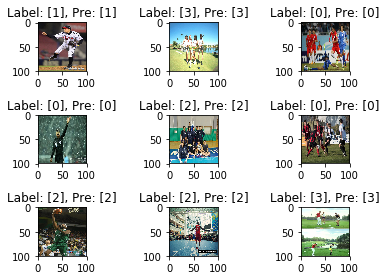

In [23]:
test = BatchGenerator(testx, testy, batch_size=len(testx),one_hot=True, nb_classes=nb_classes)

for i in range(9):
    
    r = random.randint(0, len(test.x))
    plt.subplot(3,3,i+1)
    
    
    plt.title('Label: {}, Pre: {}'.format(sess.run(tf.argmax(test.y[r:r+1], 1)),
                                                 sess.run(tf.argmax(model(X), 1), 
                                                          feed_dict={'X:0': test.x[r:r+1], 'phase:0':False})))
    b,g,r = cv2.split(test.x[r])
    plt.imshow( cv2.merge([r,g,b]))
    plt.tight_layout()